# Notebook 4

Ce notebook est découpé en plusieurs axes de travail :

- Import des packages
- Import des données
- Pre-processing
- Entrainement avec RES-NET 34
- Téléchargement images avec la carte chaleure
- Tester le modele retenu
- Traitement des fichiers résultats
- Matrice de confusion

# Import des packages

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # files handling
import re
from PIL import Image
import torchvision.transforms as transforms
from PIL import Image
import csv
import torch
import torchvision.transforms as transforms
from PIL import Image
from random import randint, seed
from IPython.display import display
import matplotlib.pyplot as plt
import json
import warnings
import requests
import seaborn as sns
warnings.filterwarnings('ignore')
import cv2
import tensorflow
from tensorflow import keras
from keras.models import Sequential # Pour construire un réseau de neurones
from keras.layers import Dense, Dropout, Flatten, LeakyReLU # Pour instancier une couche dense
from keras.utils import np_utils
from keras.layers.convolutional import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import torch.nn.functional as F
import zipfile
import seaborn as sns
print("import ok")

import ok


# Import des données

In [2]:
# Fonction pour charger toutes les images comme dans les autres packages
def load_jpeg_images(path):
    image_files = [f for f in os.listdir(path) if f.endswith('.jpg') or f.endswith('.jpeg')]
    images = []
    ids = []
    for file in image_files:
        ids.append(os.path.splitext(file)[0])
        with Image.open(os.path.join(path, file)) as image:
            image_data = np.array(image)
            img = cv2.resize(image_data, (100, 100))
            images.append(img)

    dataimage = pd.DataFrame({"ids": ids, "img": images})
    datachampi = pd.read_csv('/kaggle/input/images-bapti/dataframe/champignons.csv')

    datachampi = datachampi[['label', 'image_id']]

    dataimage[['ids']] = dataimage[['ids']].astype('int64')

    dataset = pd.merge(dataimage, datachampi, left_on='ids', right_on='image_id', how='left')

    return dataset

In [45]:
df2 = load_jpeg_images("/kaggle/input/images-bapti/images")

In [3]:
df = load_jpeg_images("/kaggle/input/images-bapti/images")
df = df.drop(index=7802)
# Mise en place du jeu de X et Y en numpy pour qu'il puisse être traité dans les réseaux de neuronnes
display(df.head())
X = df['img'].to_numpy()
Y = df['label'].to_numpy()
for i in range(len(X)):
    if str(X[i].shape) != "(100, 100, 3)":
        print("Yes"+str(X[i].shape)+str(i))

,ids,img,label,image_id
0,286008,"[[[48, 44, 55], [45, 39, 49], [35, 28, 36], [3...",Hypholoma fasciculare,286008
1,458679,"[[[91, 76, 43], [100, 75, 64], [79, 50, 41], [...",Pleurotus ostreatus,458679
2,134968,"[[[94, 70, 84], [162, 143, 129], [80, 54, 37],...",Coprinus comatus,134968
3,333550,"[[[44, 38, 16], [44, 27, 11], [35, 14, 4], [60...",Pluteus cervinus,333550
4,428572,"[[[104, 107, 112], [106, 107, 111], [111, 111,...",Fuligo septica,428572


# Pre-processing

In [4]:
# X = [np.array(x) for x in X]
# Modification de la taille de X pour que tous ces éléments soient pris en compte dans ses dimensions
X = np.stack(X)
print(X.shape)
print(Y.shape)

(9447, 100, 100, 3)
(9447,)


In [5]:
# One hot encoding
Y = pd.get_dummies(Y)

# Création du jeu d'entrainement et du jeu de test
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25)
print('Les dimensions de X_train est de '+str(X_train.shape)+'.')
print('Les dimensions de Y_train est de '+str(Y_train.shape)+'.')
print('Les dimensions de X_test est de '+str(X_test.shape)+'.')
print('Les dimensions de Y_test est de '+str(Y_test.shape)+'.')

# Redimension des jeu de train
X_train1 = X_train.reshape([-1, X_train.shape[1]*X_train.shape[2]*X_train.shape[3]])
X_test1 = X_test.reshape([-1, X_test.shape[1]*X_test.shape[2]*X_train.shape[3]])

X_train1 = X_train1/255
X_test1 = X_test1/255

nb_pixel = X_train1.shape[1]
nb_class = Y_train.shape[1]

print("\n\nLe nombre de pixels est de : ", nb_pixel)
print("Le nombre de classes est de : ", nb_class)

Les dimensions de X_train est de (7085, 100, 100, 3).
Les dimensions de Y_train est de (7085, 10).
Les dimensions de X_test est de (2362, 100, 100, 3).
Les dimensions de Y_test est de (2362, 10).


Le nombre de pixels est de :  30000
Le nombre de classes est de :  10


# Entrainement avec RES-NET 34

Entrainement sur 100 epochs

Utilisation de l'appareil: cuda


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1/100
Training Loss: 1.306
Validation Loss: 0.833
Validation Accuracy: 71.587 %


  1%|          | 1/100 [00:37<1:02:34, 37.92s/it]

Epoch: 2/100
Training Loss: 0.566
Validation Loss: 0.753
Validation Accuracy: 75.556 %


  2%|▏         | 2/100 [01:09<55:41, 34.10s/it]  

Epoch: 3/100
Training Loss: 0.276
Validation Loss: 0.785
Validation Accuracy: 75.450 %


  4%|▍         | 4/100 [02:12<51:44, 32.34s/it]

Epoch: 4/100
Training Loss: 0.154
Validation Loss: 0.775
Validation Accuracy: 77.354 %


  5%|▌         | 5/100 [02:43<50:34, 31.94s/it]

Epoch: 5/100
Training Loss: 0.075
Validation Loss: 0.842
Validation Accuracy: 78.042 %


  6%|▌         | 6/100 [03:14<49:37, 31.67s/it]

Epoch: 6/100
Training Loss: 0.053
Validation Loss: 0.846
Validation Accuracy: 77.407 %


  7%|▋         | 7/100 [03:45<48:50, 31.51s/it]

Epoch: 7/100
Training Loss: 0.030
Validation Loss: 0.874
Validation Accuracy: 77.725 %


  8%|▊         | 8/100 [04:17<48:10, 31.42s/it]

Epoch: 8/100
Training Loss: 0.023
Validation Loss: 0.874
Validation Accuracy: 77.672 %


  9%|▉         | 9/100 [04:48<47:31, 31.34s/it]

Epoch: 9/100
Training Loss: 0.035
Validation Loss: 0.951
Validation Accuracy: 77.249 %


 10%|█         | 10/100 [05:19<46:57, 31.30s/it]

Epoch: 10/100
Training Loss: 0.022
Validation Loss: 0.905
Validation Accuracy: 78.677 %


 11%|█         | 11/100 [05:50<46:25, 31.30s/it]

Epoch: 11/100
Training Loss: 0.014
Validation Loss: 0.905
Validation Accuracy: 78.413 %


 12%|█▏        | 12/100 [06:22<46:05, 31.42s/it]

Epoch: 12/100
Training Loss: 0.025
Validation Loss: 0.914
Validation Accuracy: 77.989 %
Epoch: 13/100
Training Loss: 0.009
Validation Loss: 0.915
Validation Accuracy: 78.254 %


 14%|█▍        | 14/100 [07:25<45:09, 31.50s/it]

Epoch: 14/100
Training Loss: 0.009
Validation Loss: 0.993
Validation Accuracy: 77.725 %


 15%|█▌        | 15/100 [07:57<44:40, 31.53s/it]

Epoch: 15/100
Training Loss: 0.011
Validation Loss: 0.978
Validation Accuracy: 77.196 %


 16%|█▌        | 16/100 [08:28<44:02, 31.46s/it]

Epoch: 16/100
Training Loss: 0.014
Validation Loss: 0.992
Validation Accuracy: 76.878 %


 17%|█▋        | 17/100 [09:00<43:34, 31.50s/it]

Epoch: 17/100
Training Loss: 0.010
Validation Loss: 0.971
Validation Accuracy: 77.619 %


 18%|█▊        | 18/100 [09:31<42:57, 31.44s/it]

Epoch: 18/100
Training Loss: 0.012
Validation Loss: 0.965
Validation Accuracy: 77.672 %


 19%|█▉        | 19/100 [10:02<42:16, 31.32s/it]

Epoch: 19/100
Training Loss: 0.013
Validation Loss: 0.979
Validation Accuracy: 78.519 %


 20%|██        | 20/100 [10:33<41:46, 31.33s/it]

Epoch: 20/100
Training Loss: 0.014
Validation Loss: 1.000
Validation Accuracy: 78.201 %


 21%|██        | 21/100 [11:05<41:12, 31.30s/it]

Epoch: 21/100
Training Loss: 0.012
Validation Loss: 1.006
Validation Accuracy: 78.677 %


 22%|██▏       | 22/100 [11:36<40:49, 31.41s/it]

Epoch: 22/100
Training Loss: 0.011
Validation Loss: 1.005
Validation Accuracy: 77.831 %


 23%|██▎       | 23/100 [12:08<40:25, 31.50s/it]

Epoch: 23/100
Training Loss: 0.018
Validation Loss: 1.030
Validation Accuracy: 77.407 %


 24%|██▍       | 24/100 [12:39<39:51, 31.47s/it]

Epoch: 24/100
Training Loss: 0.022
Validation Loss: 1.106
Validation Accuracy: 76.720 %


 25%|██▌       | 25/100 [13:10<39:11, 31.36s/it]

Epoch: 25/100
Training Loss: 0.016
Validation Loss: 1.059
Validation Accuracy: 77.407 %


 26%|██▌       | 26/100 [13:42<38:35, 31.29s/it]

Epoch: 26/100
Training Loss: 0.010
Validation Loss: 1.079
Validation Accuracy: 77.249 %


 27%|██▋       | 27/100 [14:13<38:03, 31.28s/it]

Epoch: 27/100
Training Loss: 0.026
Validation Loss: 1.179
Validation Accuracy: 75.820 %


 28%|██▊       | 28/100 [14:44<37:24, 31.17s/it]

Epoch: 28/100
Training Loss: 0.020
Validation Loss: 1.093
Validation Accuracy: 76.772 %


 29%|██▉       | 29/100 [15:15<36:46, 31.08s/it]

Epoch: 29/100
Training Loss: 0.012
Validation Loss: 1.101
Validation Accuracy: 76.561 %


 30%|███       | 30/100 [15:45<35:58, 30.84s/it]

Epoch: 30/100
Training Loss: 0.007
Validation Loss: 1.071
Validation Accuracy: 77.249 %


 31%|███       | 31/100 [16:15<35:18, 30.70s/it]

Epoch: 31/100
Training Loss: 0.009
Validation Loss: 1.133
Validation Accuracy: 76.878 %


 32%|███▏      | 32/100 [16:46<34:40, 30.60s/it]

Epoch: 32/100
Training Loss: 0.005
Validation Loss: 1.135
Validation Accuracy: 77.407 %


 33%|███▎      | 33/100 [17:16<34:08, 30.57s/it]

Epoch: 33/100
Training Loss: 0.009
Validation Loss: 1.125
Validation Accuracy: 77.513 %


 34%|███▍      | 34/100 [17:47<33:35, 30.54s/it]

Epoch: 34/100
Training Loss: 0.010
Validation Loss: 1.109
Validation Accuracy: 77.407 %


 35%|███▌      | 35/100 [18:17<33:00, 30.47s/it]

Epoch: 35/100
Training Loss: 0.006
Validation Loss: 1.151
Validation Accuracy: 77.249 %


 36%|███▌      | 36/100 [18:47<32:33, 30.52s/it]

Epoch: 36/100
Training Loss: 0.016
Validation Loss: 1.147
Validation Accuracy: 76.772 %


 37%|███▋      | 37/100 [19:18<32:01, 30.50s/it]

Epoch: 37/100
Training Loss: 0.009
Validation Loss: 1.122
Validation Accuracy: 78.360 %


 38%|███▊      | 38/100 [19:48<31:28, 30.46s/it]

Epoch: 38/100
Training Loss: 0.006
Validation Loss: 1.127
Validation Accuracy: 78.148 %


 39%|███▉      | 39/100 [20:19<30:57, 30.45s/it]

Epoch: 39/100
Training Loss: 0.005
Validation Loss: 1.086
Validation Accuracy: 78.148 %


 40%|████      | 40/100 [20:49<30:31, 30.53s/it]

Epoch: 40/100
Training Loss: 0.014
Validation Loss: 1.131
Validation Accuracy: 77.619 %


 41%|████      | 41/100 [21:20<30:03, 30.56s/it]

Epoch: 41/100
Training Loss: 0.006
Validation Loss: 1.127
Validation Accuracy: 78.095 %


 42%|████▏     | 42/100 [21:51<29:31, 30.55s/it]

Epoch: 42/100
Training Loss: 0.011
Validation Loss: 1.102
Validation Accuracy: 77.989 %


 43%|████▎     | 43/100 [22:21<28:53, 30.42s/it]

Epoch: 43/100
Training Loss: 0.007
Validation Loss: 1.136
Validation Accuracy: 77.937 %


 44%|████▍     | 44/100 [22:51<28:21, 30.38s/it]

Epoch: 44/100
Training Loss: 0.005
Validation Loss: 1.115
Validation Accuracy: 78.307 %


 45%|████▌     | 45/100 [23:22<27:56, 30.49s/it]

Epoch: 45/100
Training Loss: 0.004
Validation Loss: 1.088
Validation Accuracy: 79.048 %


 46%|████▌     | 46/100 [23:52<27:28, 30.52s/it]

Epoch: 46/100
Training Loss: 0.016
Validation Loss: 1.135
Validation Accuracy: 78.254 %


 47%|████▋     | 47/100 [24:23<26:59, 30.56s/it]

Epoch: 47/100
Training Loss: 0.009
Validation Loss: 1.116
Validation Accuracy: 78.254 %


 48%|████▊     | 48/100 [24:54<26:28, 30.55s/it]

Epoch: 48/100
Training Loss: 0.007
Validation Loss: 1.171
Validation Accuracy: 77.884 %


 49%|████▉     | 49/100 [25:24<26:03, 30.65s/it]

Epoch: 49/100
Training Loss: 0.017
Validation Loss: 1.170
Validation Accuracy: 76.561 %


 50%|█████     | 50/100 [25:55<25:31, 30.63s/it]

Epoch: 50/100
Training Loss: 0.006
Validation Loss: 1.137
Validation Accuracy: 77.619 %


 51%|█████     | 51/100 [26:26<24:59, 30.61s/it]

Epoch: 51/100
Training Loss: 0.005
Validation Loss: 1.112
Validation Accuracy: 78.730 %


 52%|█████▏    | 52/100 [26:56<24:30, 30.64s/it]

Epoch: 52/100
Training Loss: 0.010
Validation Loss: 1.125
Validation Accuracy: 78.201 %


 53%|█████▎    | 53/100 [27:27<24:00, 30.64s/it]

Epoch: 53/100
Training Loss: 0.030
Validation Loss: 1.116
Validation Accuracy: 77.249 %


 54%|█████▍    | 54/100 [27:58<23:29, 30.64s/it]

Epoch: 54/100
Training Loss: 0.017
Validation Loss: 1.086
Validation Accuracy: 78.254 %


 55%|█████▌    | 55/100 [28:28<23:00, 30.67s/it]

Epoch: 55/100
Training Loss: 0.009
Validation Loss: 1.189
Validation Accuracy: 77.407 %


 56%|█████▌    | 56/100 [28:59<22:29, 30.67s/it]

Epoch: 56/100
Training Loss: 0.013
Validation Loss: 1.146
Validation Accuracy: 76.984 %


 57%|█████▋    | 57/100 [29:30<21:58, 30.67s/it]

Epoch: 57/100
Training Loss: 0.056
Validation Loss: 1.164
Validation Accuracy: 75.661 %


 58%|█████▊    | 58/100 [30:00<21:26, 30.64s/it]

Epoch: 58/100
Training Loss: 0.012
Validation Loss: 1.151
Validation Accuracy: 76.402 %


 59%|█████▉    | 59/100 [30:31<20:55, 30.62s/it]

Epoch: 59/100
Training Loss: 0.008
Validation Loss: 1.121
Validation Accuracy: 77.249 %


 60%|██████    | 60/100 [31:01<20:24, 30.62s/it]

Epoch: 60/100
Training Loss: 0.006
Validation Loss: 1.137
Validation Accuracy: 78.042 %


 61%|██████    | 61/100 [31:32<19:54, 30.63s/it]

Epoch: 61/100
Training Loss: 0.014
Validation Loss: 1.154
Validation Accuracy: 77.407 %


 62%|██████▏   | 62/100 [32:03<19:23, 30.61s/it]

Epoch: 62/100
Training Loss: 0.006
Validation Loss: 1.146
Validation Accuracy: 78.466 %


 63%|██████▎   | 63/100 [32:33<18:51, 30.58s/it]

Epoch: 63/100
Training Loss: 0.004
Validation Loss: 1.132
Validation Accuracy: 78.254 %


 64%|██████▍   | 64/100 [33:03<18:16, 30.47s/it]

Epoch: 64/100
Training Loss: 0.009
Validation Loss: 1.143
Validation Accuracy: 77.196 %


 65%|██████▌   | 65/100 [33:34<17:47, 30.50s/it]

Epoch: 65/100
Training Loss: 0.008
Validation Loss: 1.172
Validation Accuracy: 77.831 %


 66%|██████▌   | 66/100 [34:04<17:16, 30.48s/it]

Epoch: 66/100
Training Loss: 0.005
Validation Loss: 1.109
Validation Accuracy: 78.889 %


 67%|██████▋   | 67/100 [34:35<16:48, 30.57s/it]

Epoch: 67/100
Training Loss: 0.013
Validation Loss: 1.133
Validation Accuracy: 78.466 %
Epoch: 68/100
Training Loss: 0.005
Validation Loss: 1.196
Validation Accuracy: 77.937 %


 69%|██████▉   | 69/100 [35:37<15:52, 30.72s/it]

Epoch: 69/100
Training Loss: 0.005
Validation Loss: 1.138
Validation Accuracy: 78.571 %


 70%|███████   | 70/100 [36:08<15:19, 30.65s/it]

Epoch: 70/100
Training Loss: 0.003
Validation Loss: 1.129
Validation Accuracy: 79.259 %


 71%|███████   | 71/100 [36:37<14:40, 30.35s/it]

Epoch: 71/100
Training Loss: 0.002
Validation Loss: 1.115
Validation Accuracy: 78.413 %


 72%|███████▏  | 72/100 [37:07<14:09, 30.32s/it]

Epoch: 72/100
Training Loss: 0.002
Validation Loss: 1.092
Validation Accuracy: 79.312 %


 73%|███████▎  | 73/100 [37:38<13:40, 30.40s/it]

Epoch: 73/100
Training Loss: 0.002
Validation Loss: 1.137
Validation Accuracy: 78.571 %


 74%|███████▍  | 74/100 [38:09<13:11, 30.45s/it]

Epoch: 74/100
Training Loss: 0.015
Validation Loss: 1.235
Validation Accuracy: 77.196 %


 75%|███████▌  | 75/100 [38:39<12:41, 30.48s/it]

Epoch: 75/100
Training Loss: 0.005
Validation Loss: 1.172
Validation Accuracy: 77.619 %


 76%|███████▌  | 76/100 [39:10<12:12, 30.51s/it]

Epoch: 76/100
Training Loss: 0.005
Validation Loss: 1.209
Validation Accuracy: 76.984 %


 77%|███████▋  | 77/100 [39:40<11:41, 30.52s/it]

Epoch: 77/100
Training Loss: 0.014
Validation Loss: 1.193
Validation Accuracy: 77.407 %


 78%|███████▊  | 78/100 [40:11<11:13, 30.59s/it]

Epoch: 78/100
Training Loss: 0.022
Validation Loss: 1.178
Validation Accuracy: 76.931 %


 79%|███████▉  | 79/100 [40:42<10:44, 30.68s/it]

Epoch: 79/100
Training Loss: 0.010
Validation Loss: 1.206
Validation Accuracy: 77.831 %


 80%|████████  | 80/100 [41:13<10:14, 30.73s/it]

Epoch: 80/100
Training Loss: 0.004
Validation Loss: 1.200
Validation Accuracy: 77.672 %


 81%|████████  | 81/100 [41:44<09:45, 30.84s/it]

Epoch: 81/100
Training Loss: 0.003
Validation Loss: 1.165
Validation Accuracy: 78.201 %


 82%|████████▏ | 82/100 [42:15<09:16, 30.90s/it]

Epoch: 82/100
Training Loss: 0.003
Validation Loss: 1.169
Validation Accuracy: 78.519 %


 83%|████████▎ | 83/100 [42:46<08:44, 30.83s/it]

Epoch: 83/100
Training Loss: 0.003
Validation Loss: 1.164
Validation Accuracy: 78.148 %


 84%|████████▍ | 84/100 [43:16<08:12, 30.81s/it]

Epoch: 84/100
Training Loss: 0.013
Validation Loss: 1.179
Validation Accuracy: 77.407 %


 85%|████████▌ | 85/100 [43:47<07:40, 30.71s/it]

Epoch: 85/100
Training Loss: 0.006
Validation Loss: 1.224
Validation Accuracy: 77.090 %


 86%|████████▌ | 86/100 [44:17<07:09, 30.67s/it]

Epoch: 86/100
Training Loss: 0.027
Validation Loss: 1.288
Validation Accuracy: 76.561 %


 87%|████████▋ | 87/100 [44:48<06:39, 30.71s/it]

Epoch: 87/100
Training Loss: 0.011
Validation Loss: 1.210
Validation Accuracy: 77.407 %


 88%|████████▊ | 88/100 [45:19<06:08, 30.73s/it]

Epoch: 88/100
Training Loss: 0.017
Validation Loss: 1.216
Validation Accuracy: 77.460 %


 89%|████████▉ | 89/100 [45:50<05:37, 30.72s/it]

Epoch: 89/100
Training Loss: 0.004
Validation Loss: 1.170
Validation Accuracy: 77.672 %


 90%|█████████ | 90/100 [46:20<05:06, 30.68s/it]

Epoch: 90/100
Training Loss: 0.006
Validation Loss: 1.153
Validation Accuracy: 78.095 %


 91%|█████████ | 91/100 [46:51<04:35, 30.64s/it]

Epoch: 91/100
Training Loss: 0.002
Validation Loss: 1.160
Validation Accuracy: 78.360 %


 92%|█████████▏| 92/100 [47:21<04:05, 30.65s/it]

Epoch: 92/100
Training Loss: 0.003
Validation Loss: 1.157
Validation Accuracy: 78.148 %


 93%|█████████▎| 93/100 [47:52<03:34, 30.64s/it]

Epoch: 93/100
Training Loss: 0.009
Validation Loss: 1.283
Validation Accuracy: 76.349 %


 94%|█████████▍| 94/100 [48:23<03:03, 30.60s/it]

Epoch: 94/100
Training Loss: 0.022
Validation Loss: 1.234
Validation Accuracy: 77.090 %


 95%|█████████▌| 95/100 [48:53<02:33, 30.60s/it]

Epoch: 95/100
Training Loss: 0.006
Validation Loss: 1.157
Validation Accuracy: 77.672 %


 96%|█████████▌| 96/100 [49:24<02:02, 30.64s/it]

Epoch: 96/100
Training Loss: 0.004
Validation Loss: 1.145
Validation Accuracy: 77.778 %


 97%|█████████▋| 97/100 [49:54<01:31, 30.57s/it]

Epoch: 97/100
Training Loss: 0.002
Validation Loss: 1.143
Validation Accuracy: 78.042 %


 98%|█████████▊| 98/100 [50:25<01:01, 30.54s/it]

Epoch: 98/100
Training Loss: 0.003
Validation Loss: 1.141
Validation Accuracy: 78.942 %


 99%|█████████▉| 99/100 [50:55<00:30, 30.34s/it]

Epoch: 99/100
Training Loss: 0.003
Validation Loss: 1.149
Validation Accuracy: 77.037 %


100%|██████████| 100/100 [51:25<00:00, 30.86s/it]

Epoch: 100/100
Training Loss: 0.016
Validation Loss: 1.186
Validation Accuracy: 77.460 %


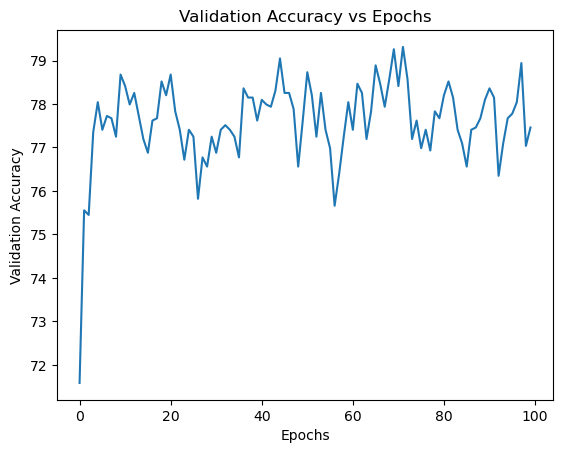

In [6]:
# vérifier la disponibilité du GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation de l'appareil: {device}")

# initialiser PyTorch
torch.backends.cudnn.benchmark = True

# définir la taille maximale pour chaque fragment
torch.backends.cudnn.benchmark = True
torch.backends.cuda.cufft_plan_cache.max_split_size_mb = 1024

class MushroomDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = '/kaggle/input/images-bapti/images/' + str(self.df.iloc[idx]['ids']) + '.jpg'
        label = label_encoder.transform([self.df.iloc[idx]['label']])[0]

        # Chargement de l'image et transformation en tensor
        img = Image.open(img_path).convert('RGB')
        img = img.resize((100, 100))

        if self.transform:
            img = self.transform(img)

        # Conversion du label en tensor
        label = torch.tensor(int(label))
        return img, label

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

img_dir = '/kaggle/input/images-bapti/images/'


# Chargement du dataset et Création du LabelEncoder et ajustement sur les labels du dataframe
label_encoder = LabelEncoder()
label_encoder.fit(df['label'])
dataset = MushroomDataset(df, transform=transform)

# Division du dataset en training set et validation set
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Création des dataloaders pour le training set et le validation set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Chargement du modèle ResNet34 pré-entraîné
model = models.resnet34(pretrained=True)

# Remplacement de la dernière couche linéaire pour notre classification en 30 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model.to(device)
# Définition de la fonction de perte et de l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Entraînement du modèle
num_epochs = 100
train_loss_history = []

# Initialisation de la liste pour stocker les valeurs de validation accuracy
val_acc_history = []


# Entraînement du modèle
for epoch in tqdm(range(100)):
    train_loss = 0.0
    valid_loss = 0.0
    correct = 0
    total = 0

    # Entraînement
    model.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    # Validation
    model.eval()
    for i, data in enumerate(val_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        valid_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calcul de la validation accuracy et stockage dans la liste
    val_accuracy = 100 * correct / total
    val_acc_history.append(val_accuracy)

    # Affichage des résultats pour cette époque
    print('Epoch: %d/%d' % (epoch+1, 100))
    print('Training Loss: %.3f' % (train_loss/len(train_loader.dataset)))
    print('Validation Loss: %.3f' % (valid_loss/len(val_loader.dataset)))
    print('Validation Accuracy: %.3f %%' % val_accuracy)
    
    # Sauvegarde du modèle
    
    torch.save(model, f'/kaggle/working/{epoch+1}_entrainement.pth')



    # Tracé de l'évolution de la validation accuracy
plt.plot(val_acc_history)
plt.title('Validation Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.show()

A la suite des 100 epochs je souhaite retenir le modele avec l'accuracy sur la validation la plus forte, c'est l'époque 72.

# Téléchargement images avec la carte chaleure

Dans cette partie, nous utilisons le modele retenu à l'époque 72 et nous le testons en affichant la carte chaleure (pixels importants dans la prédictions). Nous enregistrons les données en sortie

In [67]:
mkdir /kaggle/working/output_photo

In [94]:
# Define the list of file paths
input_dir="/kaggle/input/images-bapti/images"
file_list = [str(file_id) + ".jpg" for file_id in df["ids"]]

# Loop over each file path
for file_path in file_list:
    # Load the image
    img_path = os.path.join(input_dir, file_path)
    img = Image.open(img_path)

    # Apply the image preprocessing
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img_tensor = transform(img).unsqueeze(0).cuda()

    # Load the pre-trained model
    model = torch.load("/kaggle/input/best-train/72_entrainement.pth")

    # Get the weights of the last linear layer
    weights = list(model.parameters())[-2]

    # Extract the activations from the last convolutional layer
    features = model.conv1(img_tensor)
    features = model.bn1(features)
    features = model.relu(features)
    features = model.maxpool(features)

    features = model.layer1(features)
    features = model.layer2(features)
    features = model.layer3(features)
    features = model.layer4(features)

    features = model.avgpool(features)
    features = features.view(features.size(0), -1)

    # Make sure features is a tensor of size (1, 512, 7, 7)
    features = features.unsqueeze(-1).unsqueeze(-1)

    # Compute the CAM mask by taking the product of the weights and the activations
    cam = torch.matmul(weights, features.reshape(features.shape[0], -1).T)
    cam = cam.reshape(cam.shape[0], features.shape[-2], features.shape[-1])
    cam = F.relu(cam)

    # Normalize the CAM mask between 0 and 1
    cam = cam - cam.min()
    cam = cam / cam.max()

    # Apply a 3x3 Gaussian filter to the CAM mask
    cam = cv2.GaussianBlur(cam.detach().cpu().numpy(), (3, 3), 0)

    # Convert cam to a numpy array and resize it
    cam_np = np.expand_dims(cam, axis=0)
    cam_np = cam_np.squeeze()
    cam_np = cv2.resize(cam_np, (img.size[0], img.size[1]))

    # Scale between 0 and 255 and convert to unsigned 8-bit integer
    cam_np = 255 * cam_np
    cam_np = cam_np.astype(np.uint8)

    # Merge the image and the CAM mask
    img_np = np.array(img)
    cam_np_jet = cv2.applyColorMap(cam_np, cv2.COLORMAP_JET)
    cam_np_jet = cv2.cvtColor(cam_np_jet, cv2.COLOR_BGR2RGB)
    result = cv2.addWeighted(img_np, 0.5, cam_np_jet, 0.5, 0)
    file_name = os.path.splitext(os.path.basename(file_path))[0]
    output_file_path = os.path.join(os.path.dirname(file_path), file_name + "_output.jpg")
    cv2.imwrite(output_file_path, result)


In [99]:
comptagefini = len(os.listdir("/kaggle/working/"))
print('Il y a bien ', comptagefini , "images en sorties")

Il y a bien  9447 images en sorties


Telechargement des images

In [100]:
# Chemin du dossier contenant les images
path = "/kaggle/working/"

# Création d'une liste des noms de fichiers des images
image_files = [f for f in os.listdir(path) if f.endswith('.jpg') or f.endswith('.png')]

# Nom de l'archive zip
zip_filename = "images.zip"

# Création de l'archive zip
with zipfile.ZipFile(zip_filename, 'w') as zip_file:
    for image in image_files:
        zip_file.write(os.path.join(path, image), image)

# Téléchargement de l'archive zip depuis le notebook
from IPython.display import FileLink
display(FileLink(zip_filename))


/kaggle/working/images.zip

# Tester le modele retenu

Dans cette partie, on prédit le label sur les photos et sauvegarde des résultats dans un csv.

In [25]:
mkdir /kaggle/working/output_csv

In [26]:
# Vérifier la disponibilité du GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation de l'appareil: {device}")

# Charger le modèle
model = torch.load("/kaggle/input/best-train/72_entrainement.pth")
model.to(device)

# Préparer les transformations d'images
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Lire les images et faire les prédictions
image_dir = "/kaggle/input/images-bapti/images"
results = []
count = 0
total = len(os.listdir(image_dir))
for filename in os.listdir(image_dir):
    if filename.endswith(".jpg"):
        # Charger l'image
        img_path = os.path.join(image_dir, filename)
        img = Image.open(img_path).convert('RGB')
        img = transform(img)
        img = img.unsqueeze(0).to(device)

        # Faire la prédiction
        with torch.no_grad():
            model.eval()
            outputs = model(img)
            _, predicted = torch.max(outputs.data, 1)
            predicted_label = predicted.cpu().numpy()[0]

        # Ajouter les résultats à la liste
        results.append((filename, predicted_label))
        
        # Afficher la progression
        count += 1
        if count % (total // 10) == 0:
            print(f"{count}/{total} images traitées")

# Écrire les résultats dans un fichier CSV
with open('/kaggle/working/output_csv/predictions.csv', mode='w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Nom de l\'image', 'Label prédit'])
    for result in results:
        writer.writerow(result)

print("Prédictions enregistrées dans le fichier predictions.csv")


Utilisation de l'appareil: cuda
944/9447 images traitées
1888/9447 images traitées
2832/9447 images traitées
3776/9447 images traitées
4720/9447 images traitées
5664/9447 images traitées
6608/9447 images traitées
7552/9447 images traitées
8496/9447 images traitées
9440/9447 images traitées
Prédictions enregistrées dans le fichier predictions.csv


# Traitement des fichiers resultats

On encode les labels entre 0 et 9

In [178]:
df_subset = df[['label', 'image_id']]
df_subset['image_id'] = df_subset['image_id'].astype(str) + '.jpg'
df_subset['label'] = df_subset['label'].replace({
    'Amanita phalloides': 0,
    'Coprinellus micaceus': 1,
    'Coprinus comatus': 2,
    'Fuligo septica': 3,
    'Galerina marginata': 4,
    'Hypholoma fasciculare': 5,
    'Laetiporus sulphureus': 6,
    'Pleurotus ostreatus': 7,
    'Pluteus cervinus': 8,
    'Schizophyllum commune': 9
})
df_realite=df_subset

In [179]:
df_pred = pd.read_csv('/kaggle/input/res-pred/predictions.csv')
df_pred = df_pred.rename(columns={'Nom de l\'image': 'image_id'})
df_final = pd.merge(df_pred, df_realite, on='image_id')

# Matrice de confusion

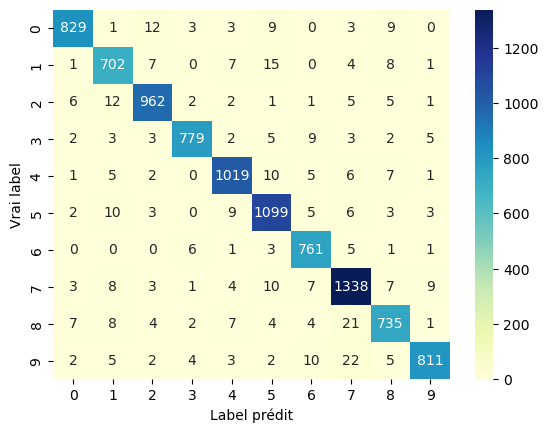

In [181]:
# créer la matrice de confusion
confusion_matrix = pd.crosstab(df_final["label"], df_final["Label prédit"], rownames=["Vrai label"], colnames=["Label prédit"])

# afficher la matrice de confusion avec des couleurs
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.show()

# Manipulation pour tableau de Bord

In [182]:
# créer la colonne "image_id_short"
df_final["image_id_short"] = df_final["image_id"].apply(lambda x: x[:-4])

# créer les colonnes "Label_Predit_Nom" et "label_nom"
label_dict = {0: 'Amanita phalloides', 1: 'Coprinellus micaceus', 2: 'Coprinus comatus', 3: 'Fuligo septica',
              4: 'Galerina marginata', 5: 'Hypholoma fasciculare', 6: 'Laetiporus sulphureus',
              7: 'Pleurotus ostreatus', 8: 'Pluteus cervinus', 9: 'Schizophyllum commune'}
df_final["Label_Predit_Nom"] = df_final["Label prédit"].apply(lambda x: label_dict[x])
df_final["label_nom"] = df_final["label"].apply(lambda x: label_dict[x])
df_final['photo_output'] = df_final['image_id'].apply(lambda x: x[:-4] + "_output.jpg")

# remettre les colonnes dans un ordre plus intuitif
df_final = df_final.reindex(columns=["image_id_short", "image_id","photo_output", "label", "label_nom", "Label prédit", "Label_Predit_Nom"])
# renommer
df_final = df_final.rename(columns={
    "image_id_short": "ID",
    "image_id": "Image_Entree",
    "photo_output": "Image_Sortie",
    "label": "Label_Num_Entree",
    "label_nom": "Label_Nom_Entree",
    "Label prédit": "Label_Num_Sortie",
    "Label_Predit_Nom": "Label_Nom_Sortie"
})

# afficher le nouveau dataframe
df_final.head(5)

,ID,Image_Entree,Image_Sortie,Label_Num_Entree,Label_Nom_Entree,Label_Num_Sortie,Label_Nom_Sortie
0,286008,286008.jpg,286008_output.jpg,5,Hypholoma fasciculare,5,Hypholoma fasciculare
1,458679,458679.jpg,458679_output.jpg,7,Pleurotus ostreatus,7,Pleurotus ostreatus
2,134968,134968.jpg,134968_output.jpg,2,Coprinus comatus,2,Coprinus comatus
3,333550,333550.jpg,333550_output.jpg,8,Pluteus cervinus,8,Pluteus cervinus
4,428572,428572.jpg,428572_output.jpg,3,Fuligo septica,3,Fuligo septica


In [184]:
df_final.to_csv('/kaggle/working/df_tableau_bord.csv', index=False)